In [1]:
BRANCH = 'r1.12.0'
# # If you're using Google Colab and not running locally, uncomment and run this cell.
!apt-get install sox libsndfile1 ffmpeg
!pip install wget unidecode
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/nemo_text_processing/install_pynini.sh
!bash install_pynini.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 22 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://

In [2]:
!pip freeze | grep torch

pytorch-lightning==1.7.6
torch @ https://download.pytorch.org/whl/cu113/torch-1.12.1%2Bcu113-cp37-cp37m-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu113/torchaudio-0.12.1%2Bcu113-cp37-cp37m-linux_x86_64.whl
torchmetrics==0.10.0
torchsummary==1.5.1
torchtext==0.13.1
torchvision @ https://download.pytorch.org/whl/cu113/torchvision-0.13.1%2Bcu113-cp37-cp37m-linux_x86_64.whl


In [14]:
from ipywidgets import Select, HBox, Label
from IPython.display import display

supported_spec_gen = ["tacotron2", "fastpitch", None]
supported_audio_gen = ["waveglow", "hifigan", "griffin-lim", None]

print("Select the model(s) that you want to use. Please choose 1 spectrogram generator and 1 vocoder.")
spectrogram_generator_selector = Select(options=supported_spec_gen, value=None)
audio_generator_selector = Select(options=supported_audio_gen, value=None)
display(HBox([spectrogram_generator_selector, Label("+"), audio_generator_selector]))

Select the model(s) that you want to use. Please choose 1 spectrogram generator and 1 vocoder.


In [16]:
spectrogram_generator = spectrogram_generator_selector.value
audio_generator = audio_generator_selector.value

if spectrogram_generator is None and audio_generator is None:
    raise ValueError("No models were chosen. Please return to the previous step and choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")

if (spectrogram_generator and audio_generator is None) or (audio_generator and spectrogram_generator is None):
    raise ValueError("In order to continue with the two step pipeline, both the spectrogram generator and the audio generator must be chosen, but one was `None`")

In [15]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder, TextToWaveform


def load_spectrogram_model():
    override_conf = None
    
    from_pretrained_call = SpectrogramGenerator.from_pretrained
    
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "tts_en_tacotron2"
    elif spectrogram_generator == "fastpitch":
        from nemo.collections.tts.models import FastPitchModel
        pretrained_model = "tts_en_fastpitch"
    else:
        raise NotImplementedError
        
    model = from_pretrained_call(pretrained_model, override_config_path=override_conf)
    
    return model


def load_vocoder_model():
    TwoStagesModel = False
    strict=True
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "tts_waveglow"
        strict=False
    elif audio_generator == "hifigan":
        from nemo.collections.tts.models import HifiGanModel
        spectrogram_generator2ft_hifigan = {
            "mixertts": "tts_en_lj_hifigan_ft_mixertts",
            "mixerttsx": "tts_en_lj_hifigan_ft_mixerttsx"
        }
        pretrained_model = spectrogram_generator2ft_hifigan.get(spectrogram_generator, "tts_hifigan")
    elif audio_generator == "griffin-lim":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': 1024, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': 22050, 'n_fft': 1024, 
                                   'mel_fmin': 0, 'mel_fmax': 8000, 'mel_freq': 80}}}
        model = TwoStagesModel(cfg)            
        TwoStagesModel = True
    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model, strict=strict)
        
    return model

spec_gen = load_spectrogram_model().eval().cuda()
vocoder = load_vocoder_model().eval().cuda()

[NeMo I 2022-10-18 04:29:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.12.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.
[NeMo I 2022-10-18 04:29:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.12.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo
[NeMo I 2022-10-18 04:29:18 common:910] Instantiating model from pre-trained checkpoint


[NeMo W 2022-10-18 04:29:19 modelPT:143] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      trim: false
      int_values: false
      load_audio: true
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2022-10-18 04:29:19 modelPT:150] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_

[NeMo I 2022-10-18 04:29:19 features:225] PADDING: 16
[NeMo I 2022-10-18 04:29:20 save_restore_connector:243] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_1.12.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.
[NeMo I 2022-10-18 04:29:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.12.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo.
[NeMo I 2022-10-18 04:29:20 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.12.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo
[NeMo I 2022-10-18 04:29:20 common:910] Instantiating model from pre-trained checkpoint


[NeMo W 2022-10-18 04:29:23 modelPT:143] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      n_segments: 16000
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 12
      num_workers: 4
    
[NeMo W 2022-10-18 04:29:23 modelPT:150] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_val.json

[NeMo I 2022-10-18 04:29:23 features:225] PADDING: 16
[NeMo I 2022-10-18 04:29:24 save_restore_connector:243] Model WaveGlowModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.12.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo.


In [17]:
def infer(spec_gen_model, vocoder_model, str_input):
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        gen_spec_kwargs = {}
        
        if spectrogram_generator == "mixerttsx":
            gen_spec_kwargs["raw_texts"] = [str_input]
        
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, **gen_spec_kwargs)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
        if audio_generator == "hifigan":
            audio = vocoder_model._bias_denoise(audio, spectrogram).squeeze(1)
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [18]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(spec_gen, vocoder, text_to_generate)

Input what you want the model to say: 


[NeMo W 2022-10-18 04:29:54 tacotron2:341] Reached max decoder steps 1000.


# Results



In [19]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

ipd.Audio(audio, rate=22050)

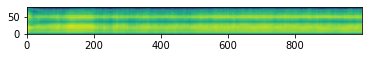

In [20]:
%matplotlib inline
if spec is not None:
    imshow(spec, origin="lower")
    plt.show()

In [21]:
#Input file with the sentences goes here
with open('dataset1.txt') as f:
    lines = [line.rstrip() for line in f]

[NeMo W 2022-10-18 04:30:26 tacotron2:341] Reached max decoder steps 1000.


[NeMo W 2022-10-18 04:30:30 tacotron2:341] Reached max decoder steps 1000.


[NeMo W 2022-10-18 04:30:33 tacotron2:341] Reached max decoder steps 1000.


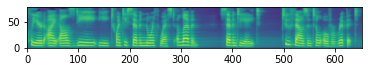

In [22]:
import IPython.display as ipd
import librosa.display
import librosa
import soundfile as sf
count=1
for i in lines:
  text_to_generate = i
  spec, audio = infer( spec_gen, vocoder, text_to_generate)
  display(ipd.Audio(audio, rate=22050))
  imshow(spec, origin="lower")
